# Project task 01: Duplicate detection with LSH

In [30]:
import numpy as np
import scipy.sparse as sp
import re
import json
import time

from scipy.sparse import linalg as spl
from collections import defaultdict
from IPython.display import Markdown, display

import matplotlib.pyplot as plt
%matplotlib inline

The goal of this task is to find duplicate reviews in the Yelp dataset. You can imagine a scenario were the **same** review appears for a restaurant with only small variation (e.g. few words are changed), or some user is trying to submit spam reviews.

## 1. Load data

We'll be working with reviews for restaurants in Las Vegas. 

The data includes:
* ([download link](https://syncandshare.lrz.de/dl/fiUuDugamX2JCH33hkxYXgdF)) the preprocessed data matrix: `bow_subset.npz`, 
* ([download link](https://syncandshare.lrz.de/dl/fiMX6taWPMEQ9aaznq4oadyq)) the words in our vocabulary: `top_25k_words.npy`, 
* ([download link](https://syncandshare.lrz.de/dl/fiLLqkiVLXGQPnrj7UvLtBbN)) orginal raw data: `reviews_subset.json`, 

In [31]:
words = np.load('top_25k_words.npy')
bow_subset = sp.load_npz('bow_subset.npz')
N = bow_subset.shape[0]

with open('reviews_subset.json' , 'r') as f:
    reviews = json.load(f)

The size of the data matrix should be $100K \times 25K$. Meaning we have $100K$ reviews, and each review is represented as bag-of-words vector of size $25K$.

In [32]:
print(bow_subset.shape)

(100000, 25000)


For each of the $25K$ we can see which word is associated with it.

In [33]:
print(words)

['food' 'good' 'place' ..., "burke's" 'electronica' 'peels']


We can also inspect how the raw data looks like.

In [34]:
reviews[0]

{'biz': {'categories': ['Restaurants', 'Steakhouses'],
  'city': 'Las Vegas',
  'name': "Gallagher's Steakhouse"},
 'business_id': 'nnDLapJk1z2NJE0-XzwMlQ',
 'review_id': '0Lx-agcwqjNhS4JtCVqkHQ',
 'stars': 5,
 'text': "The surf and turf here was one of the best I've had.\n\nFilet mignon and lobster tail was very good.  i generally dont think the food in Vegas is great, but after being dissappointed on many occasions, I was pleasantly surprised with the quality of our meal.  Thanks to the Taste, i was lured to this restaurant only to find that it is a somehat hidden jewel in New York New York close to the sometimes obnoxious piana bar time square.  \n\nThe side of green beans were delish and the potatos are just meh.\n\nFor desert they  served an extremely delicious lemon pudding which taste more tart than pudding....it was fabulous.\n\nI think Gallaghers is good for couples, groups, and even kids.",
 'user_id': 'M63uPVZtCv7ReY2RgJRmOw'}

## 2. Implementaion

Your task is to implement duplicate detection using LSH with cosine similarity.
More specifically you have to:
* Generate duplicate **candidates** based on LSH with $b$ bands and $r$ rows per band
* Refine the candidates by computing the exact cosine distance
* Report all pairs/duplicates with cosine distance < $d$

We provide a helper function that computes the cosine distance between two rows of a given sparse matrix.

In [35]:
def cosine_distance(X, i, j):
    """Compute cosine distance between two rows of a sparse matrix.
    
    Parameters
    ----------
    X : sp.spmatrix, shape [N, D]
        Sparse data matrix.
    i : int
        Index of the first row.
    j : int
        Index of the second row.
        
    Returns
    -------
    d : float
        Cosine distance between the two rows of the sparse matrix.
        
    """
    i_norm = spl.norm(X[i])
    j_norm = spl.norm(X[j])
    ij_dot = X[i].dot(X[j].T)[0, 0]
    
    return 1-ij_dot/(i_norm*j_norm)

In [36]:
import itertools

def make_planes(size, dim, seed):
    np.random.seed(seed)
    p = []
    for i in range(size):
        p.append(np.random.normal(0, 1, dim).tolist())
        #p.append(np.random.uniform(-1, 1, dim).tolist())
    return p

In [37]:
def LSH(X, b=8, r=32, d=0.3):
    """Find candidate duplicate pairs using LSH and refine using exact cosine distance.
    
    Parameters
    ----------
    X : sp.spmatrix, shape [N, D]
        Sparse data matrix.
    b : int
        Number of bands.
    r : int
        Number of rows per band.
    d : float
        Distance treshold for reporting duplicates.
    
    Returns
    -------
    duplicates : {(ID1, ID2, d_{12}), ..., (IDX, IDY, d_{xy})}
        A set of tuples indicating the detected duplicates.
        Each tuple should have 3 elements:
            * ID of the first review
            * ID of the second review
            * The cosine distance between them
    
    n_candidates : int
        Number of detected candidate pairs.
        
    """
    np.random.seed(158)
    n_candidates = 0
    duplicates = set()
    
    ### YOUR CODE HERE ###
    ### Genrating a signature matrix###
    planes = make_planes(size=b*r,dim=X.shape[1],seed=158)
    planes = np.asmatrix(planes)
    sketch = planes * X.transpose()
    sketch[sketch > 0] = 1
    sketch[sketch <= 0] = 0
    detectedPairs = {}
    dic = defaultdict(list)
    for x in range(b):  
        for y in range(sketch.shape[1]):
            reviewValues = sketch[(x*r):(r*(x+1)),[y]]
            reviewValues = reviewValues.transpose().tolist()
            binaryReview = ''.join(str(int(v)) for v in reviewValues[0])
            reviewHashValue = int(binaryReview, 2)
            dic['{}{}'.format(reviewHashValue, x)].append(y)
          
    for k,v in dic.items(): 
        if(len(v) > 1):
            allCandidates = list(itertools.combinations(v, 2))
            for pair in allCandidates:
                if not '{}{}'.format(pair[0], pair[1]) in detectedPairs.keys():
                    detectedPairs['{}{}'.format(pair[0], pair[1])] = 1
                    n_candidates = n_candidates + 1
                    d_ij = cosine_distance(X,pair[0],pair[1])
                    if(d_ij < d and pair[0] != pair[1]):
                        duplicates.add((pair[0], pair[1], d_ij))

                        
    
    return duplicates, n_candidates

In [38]:
duplicates, n_candidates = LSH(bow_subset, b=6, r=28, d=0.2)

In [39]:
print('We detected {} candidates.'.format(n_candidates))

We detected 826 candidates.


Show the duplicates we have found:

In [40]:
duplicates

{(1809, 13244, 0.0),
 (6600, 93310, 0.0),
 (17779, 72702, 1.1102230246251565e-16),
 (32066, 71726, 0.0),
 (35163, 82597, 1.1102230246251565e-16),
 (42795, 95179, 0.0),
 (47940, 65607, 0.0),
 (64525, 70002, 0.12712843905603044)}

Get the raw data for the reviews that were detected as duplicates:

In [41]:
similar_review_pairs = []
for ix1, ix2, sim in duplicates:
    rev1 = reviews[ix1]
    rev2 = reviews[ix2]
    similar_review_pairs.append((rev1, rev2, sim))

Print the all the detected pairs that are not exact duplicates, highlighting the words that are present in our vocabulary:

In [42]:
pattern = re.compile('(\S+|\n)')
pattern_punctuation = re.compile('^\W+|\W+$')

def highlight_vocabulary(text, vocabulary):
    split = re.findall(r"[\w']+", text)
    in_vocabulary = [pattern.sub(lambda m: pattern_punctuation.sub('', m.group()), str.lower(x)) in words for x in split]
    highlighted_words = ["**{}**".format(x) if in_vocabulary[ix] else x for ix,x in enumerate(split) ]
    highlighted_text = " ".join(highlighted_words)
    return highlighted_text

def printmd(string):
    display(Markdown(string))

In [43]:
for r1, r2, sim in similar_review_pairs:
    if not np.isclose(sim, 0.0):
        printmd(highlight_vocabulary(r1['text'], words))
        print("")
        print("vs.")
        print("")
        printmd(highlight_vocabulary(r2['text'], words))
        print("===")
        print("Same business: {}".format(r1['business_id'] == r2['business_id']))
        print("Same user: {}".format(r1['user_id'] == r2['user_id']))
        print("Cosine distance {:.4f}".format(sim))
        print("")    
        print("#######")
        print("")

**Good** **Service** **Good** **food**


vs.



**Service** is **good** very **friendly** and **good** **food** who **could** **want** more nagar it was very **good**

===
Same business: False
Same user: False
Cosine distance 0.1271

#######



## 3. Intractability (Optional)

You can optionally verify for yourself that a naive distance computation is not feasible on a dataset of this size.

For example, we get an out of memory error on a machine with 64GB RAM. 

**Be careful, if you do decide to uncomment and run the code in the next cell your machine may freeze.**

In [44]:
# from sklearn.metrics.pairwise import pairwise_distances
# distances = pairwise_distances(bow_subset, metric='cosine')

We can potentially deal with the out of memory error by examining the pairs sequentially and saving only the potential candidates. This would take $O(N^2)$ time.

In [45]:
# naively compute the duplicates using a double for loop
def naive_duplicates(X, d = 0.2):
    """
    Parameters
    ----------
    X : sp.spmatrix, shape [N, D]
        Sparse data matrix.
    d : float
        Distance treshold for reporting duplicates.
    
    Returns
    -------
    duplicates : {(ID1, ID2, d_{12}), ..., (IDX, IDY, d_{xy})}
        A set of tuples indicating the detected duplicates.
        Each tuple should have 3 elements:
            * ID of the first review
            * ID of the second review
            * The cosine distance between them
    """
    N = X.shape[0]
    duplicates = set()
    for i in range(N):
        for j in range(N):
            d_ij = cosine_distance(X, i, j)
            if d_ij < d and i != j:
                duplicates.add((i, j, d_ij))
    return duplicates

## 4. Compare runtime

Your task is to implement code for runtime comparison between LSH and the naive nested for loop implementation.

In [46]:
def runtime_comparison():
    """
    Compare the runtime between LSH and the naive approach.
    
    Returns
    -------
    trace : [(n1, lsh_dur, naive_dur), (n2, lsh_dur, naive_dur), ... ]
            A list of tuples with execution times for different number of reviews.
            Each tuple should have 3 elements:
                * number of reviews considered
                * duration of the LSH approach
                * duration of the naive approach
    """
    trace = []
    for n in np.arange(25, 251, 25):
        print('Running comparison for {} reviews.'.format(n))
        ### YOUR CODE HERE ###
        subSet = bow_subset[0:n,:]
        start = time.clock()
        LSH(bow_subset[0:n,:], b=6, r=28, d=0.2)
        end = time.clock()
        timeLSH = end - start
        start = time.clock()
        naive_duplicates(subSet, d = 0.2)
        end = time.clock()
        timeNaive = end - start
        trace.append((n,timeLSH,timeNaive))
        
    return trace

In [47]:
trace = runtime_comparison()

Running comparison for 25 reviews.
Running comparison for 50 reviews.
Running comparison for 75 reviews.
Running comparison for 100 reviews.
Running comparison for 125 reviews.
Running comparison for 150 reviews.
Running comparison for 175 reviews.
Running comparison for 200 reviews.
Running comparison for 225 reviews.
Running comparison for 250 reviews.


Plot the differecene in runtime. On the x-axis plot the number of reviews processed and on the y-axis plot the runtime in seconds for both approaches. You should obtain a plot similar to the one shown below.

In [48]:
### YOUR PLOTTING CODE HERE ###

In [49]:
x, y1, y2 = zip(*trace)

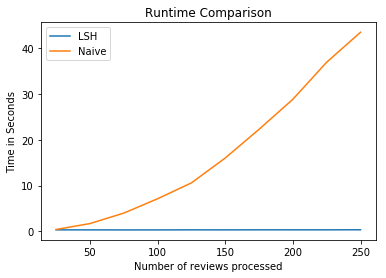

In [50]:
plt.plot(x,y1,label = "LSH")
plt.plot(x,y2,label = "Naive")
plt.legend()
plt.title('Runtime Comparison')
plt.xlabel('Number of reviews processed')
plt.ylabel('Time in Seconds')
plt.show()